# Notebook 5: Sensitivity Analysis (Heatmaps).


Block 1: Logic & Engine

We create a self-contained function to calculate NPV for thousands of different scenarios instantly.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 5: Sensitivity Analysis (Heatmaps) ---")

# --- 1. Redefine Core Logic (for standalone execution) ---
# We need the DCF engine here to run hundreds of scenarios

def get_s_curve_weights(duration):
    """Standard Normal CDF S-curve"""
    x_norm = np.linspace(-3, 3, duration + 1)
    cdf = norm.cdf(x_norm)
    weights = np.diff(cdf)
    return weights / weights.sum()

def calculate_npv_scenario(cost_kw, power_price, duration=8, wacc=0.08, capacity_mw=1100):
    """
    Calculates NPV for a specific combination of Cost and Price.
    """
    # --- Construction Phase (Outflows) ---
    total_capex_m = (capacity_mw * 1000 * cost_kw) / 1e6
    weights = get_s_curve_weights(duration)
    const_flows = -total_capex_m * weights

    # --- Operational Phase (Inflows) ---
    # Assumptions from NB3
    life = 60
    cf = 0.92
    gen_mwh = capacity_mw * 8760 * cf

    # OPEX ($M/yr)
    fixed_om = (capacity_mw * 1000 * 100) / 1e6 # $100/kW-yr
    var_om_fuel = (gen_mwh * 9.0) / 1e6 # $9/MWh (Fuel+Var)
    total_opex = fixed_om + var_om_fuel

    revenue = (gen_mwh * power_price) / 1e6
    op_cashflow = revenue - total_opex

    op_flows = np.repeat(op_cashflow, life)

    # --- Combine & Discount ---
    all_flows = np.concatenate([const_flows, op_flows])
    times = np.arange(len(all_flows))

    # Discount
    pv = all_flows / ((1 + wacc) ** times)
    return pv.sum()

print("Sensitivity Engine ready.")

--- Notebook 5: Sensitivity Analysis (Heatmaps) ---
Sensitivity Engine ready.


Block 2: The Matrix Calculation

We loop through a wide range of Costs ($3k-$13k) and Prices ($40-$140) to build our heatmap data.

In [23]:
# --- 2. Run Sensitivity Matrix ---
print("Running 2D Sensitivity Analysis (Price vs. Cost)...")

# Define Ranges
costs = np.arange(3000, 13000, 1000) # $3k to $12k per kW
prices = np.arange(40, 140, 10)      # $40 to $130 per MWh

results = []

for c in costs:
    for p in prices:
        npv = calculate_npv_scenario(cost_kw=c, power_price=p)
        results.append({
            'Overnight_Cost ($/kW)': c,
            'Power_Price ($/MWh)': p,
            'NPV ($M)': npv
        })

df_sens = pd.DataFrame(results)

# Pivot for Heatmap
matrix_npv = df_sens.pivot(index='Power_Price ($/MWh)', columns='Overnight_Cost ($/kW)', values='NPV ($M)')

Running 2D Sensitivity Analysis (Price vs. Cost)...


Block 3: Visualizing the Valley of Death

We plot the famous "J-Curve" which visually demonstrates the depth of the capital hole and the time required to climb out of it.

Heatmap generated. Green = Profitable, Red = Value Destructive.


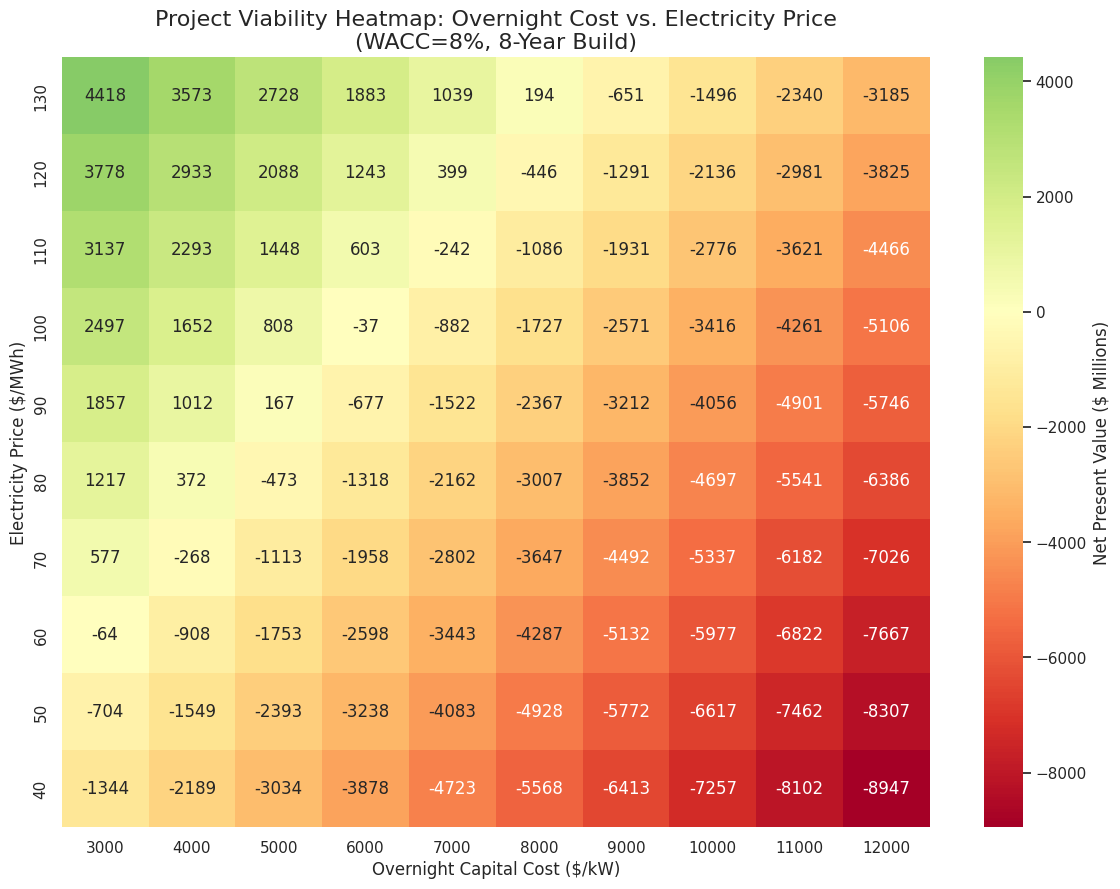


Calculating Breakeven Construction Cost for fixed Power Prices...
   Power Price  Max Affordable Cost
0           60                 2900
1           80                 4400
2          100                 5900
3          120                 7400


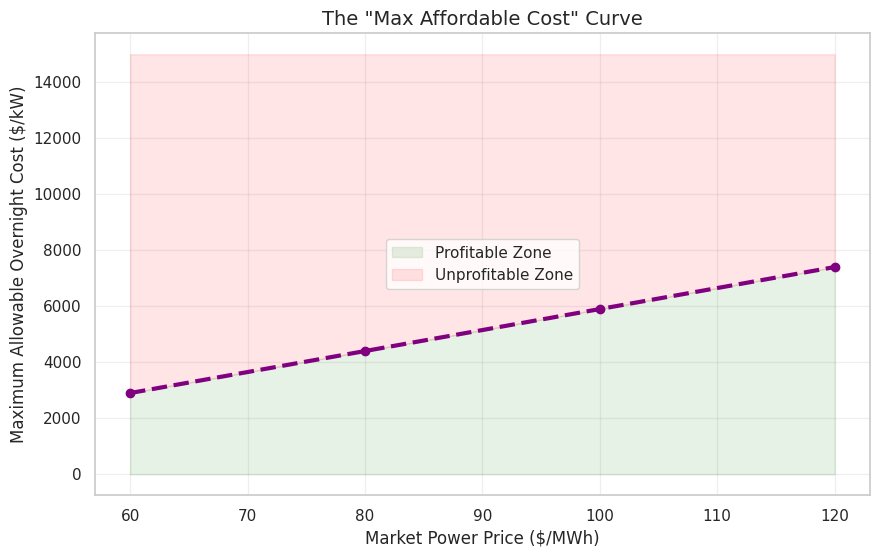

Sensitivity Matrix saved to 'sensitivity_matrix.csv'. Ready for Notebook 6.


In [24]:
# --- 3. Visualization ---
plt.figure(figsize=(14, 10))

# Custom heatmap
# We want the Y-axis to be high price at top (standard chart logic)
matrix_npv_plot = matrix_npv.sort_index(ascending=False)

ax = sns.heatmap(
    matrix_npv_plot,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",
    center=0,
    cbar_kws={'label': 'Net Present Value ($ Millions)'}
)

plt.title('Project Viability Heatmap: Overnight Cost vs. Electricity Price\n(WACC=8%, 8-Year Build)', fontsize=16)
plt.xlabel('Overnight Capital Cost ($/kW)')
plt.ylabel('Electricity Price ($/MWh)')

# Highlight the "Investment Grade" zone (Green)
print("Heatmap generated. Green = Profitable, Red = Value Destructive.")
plt.show()

# --- 4. The "Breakeven Cost" Analysis ---
# For a given power price, what is the max cost we can afford?
print("\nCalculating Breakeven Construction Cost for fixed Power Prices...")

target_prices = [60, 80, 100, 120]
breakeven_costs = []

for p in target_prices:
    # Simple linear search or interpolation
    # We'll just run a finer grain loop for this specific line
    fine_costs = np.arange(2000, 15000, 100)
    for c in fine_costs:
        npv = calculate_npv_scenario(cost_kw=c, power_price=p)
        if npv < 0:
            breakeven_costs.append({'Power Price': p, 'Max Affordable Cost': c - 100})
            break

df_be = pd.DataFrame(breakeven_costs)
print(df_be)

# Plot Breakeven
plt.figure(figsize=(10, 6))
plt.plot(df_be['Power Price'], df_be['Max Affordable Cost'], marker='o', color='purple', linewidth=3, linestyle='--')
plt.fill_between(df_be['Power Price'], df_be['Max Affordable Cost'], 0, color='green', alpha=0.1, label='Profitable Zone')
plt.fill_between(df_be['Power Price'], df_be['Max Affordable Cost'], 15000, color='red', alpha=0.1, label='Unprofitable Zone')

plt.title('The "Max Affordable Cost" Curve', fontsize=14)
plt.xlabel('Market Power Price ($/MWh)')
plt.ylabel('Maximum Allowable Overnight Cost ($/kW)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 5. Export
df_sens.to_csv('sensitivity_matrix.csv', index=False)
print("Sensitivity Matrix saved to 'sensitivity_matrix.csv'. Ready for Notebook 6.")